In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report

In [2]:
matches = pd.read_csv('matches.csv', index_col=0)

print(matches.shape)

(2244, 28)


In [3]:
matches['Team'].value_counts()

Team
Chelsea                     113
Aston Villa                 113
Tottenham Hotspur           113
Manchester United           113
Newcastle United            112
Manchester City             112
Arsenal                     112
Liverpool                   112
Brentford                   112
Nottingham Forest           112
Fulham                      112
Brighton and Hove Albion    112
Crystal Palace              112
Everton                     112
Wolverhampton Wanderers     112
Bournemouth                 112
West Ham United             112
Leicester City               74
Southampton                  74
Luton Town                   38
Sheffield United             38
Burnley                      38
Leeds United                 38
Ipswich Town                 36
Name: count, dtype: int64

In [4]:
matches['Opponent'].value_counts()

Opponent
Manchester Utd     113
Chelsea            113
Tottenham          113
Aston Villa        113
Wolves             112
Bournemouth        112
Nott'ham Forest    112
Brentford          112
Liverpool          112
Crystal Palace     112
Brighton           112
Arsenal            112
Newcastle Utd      112
Manchester City    112
Fulham             112
West Ham           112
Everton            112
Southampton         74
Leicester City      74
Burnley             38
Luton Town          38
Sheffield Utd       38
Leeds United        38
Ipswich Town        36
Name: count, dtype: int64

In [5]:
matches.dtypes

Date              object
Time              object
Comp              object
Round             object
Day               object
Venue             object
Result            object
GF                 int64
GA                 int64
Opponent          object
xG               float64
xGA              float64
Poss               int64
Attendance       float64
Captain           object
Formation         object
Opp Formation     object
Referee           object
Match Report      object
Notes            float64
Sh                 int64
SoT                int64
Dist             float64
FK                 int64
PK                 int64
PKatt              int64
Season             int64
Team              object
dtype: object

In [6]:
team_names = matches['Team'].unique()
opp_names = matches['Opponent'].unique()

for i in team_names:
    if (i not in opp_names):
        print(i)

Newcastle United
Nottingham Forest
Brighton and Hove Albion
Wolverhampton Wanderers
West Ham United
Manchester United
Tottenham Hotspur
Sheffield United


In [7]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    'Newcastle United': 'Newcastle Utd',
    'Nottingham Forest': "Nott'ham Forest",
    'Brighton and Hove Albion': 'Brighton',
    'Wolverhampton Wanderers': 'Wolves',
    'West Ham United': 'West Ham',
    'Manchester United': 'Manchester Utd',
    'Tottenham Hotspur': 'Tottenham',
    'Sheffield United': 'Sheffield Utd'
}

mapping = MissingDict(**map_values)

In [8]:
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
0,2024-08-17,12:30 (21:30),Premier League,Matchweek 1,Sat,Away,W,2,0,Ipswich Town,...,Match Report,NaN,18,5,14.8,0,0,0,2025,Liverpool
1,2024-08-25,16:30 (01:30),Premier League,Matchweek 2,Sun,Home,W,2,0,Brentford,...,Match Report,NaN,19,8,13.6,1,0,0,2025,Liverpool
2,2024-09-01,16:00 (01:00),Premier League,Matchweek 3,Sun,Away,W,3,0,Manchester Utd,...,Match Report,NaN,11,3,13.4,0,0,0,2025,Liverpool
3,2024-09-14,15:00 (00:00),Premier League,Matchweek 4,Sat,Home,L,0,1,Nott'ham Forest,...,Match Report,NaN,14,5,14.9,0,0,0,2025,Liverpool
5,2024-09-21,15:00 (00:00),Premier League,Matchweek 5,Sat,Home,W,3,0,Bournemouth,...,Match Report,NaN,19,12,16.6,0,0,0,2025,Liverpool


In [10]:
matches['Team'] = matches['Team'].map(mapping)
team_mapping_dict = {key: value for key, value in zip(matches['Team'], matches['Team'].astype('category').cat.codes)}
matches['Team_code'] = matches['Team'].map(team_mapping_dict)
matches['Opp_code'] = matches['Opponent'].map(team_mapping_dict)

matches['Date'] = pd.to_datetime(matches['Date'])
matches['Venue_code'] = matches['Venue'].astype('category').cat.codes
matches['Hour'] = matches['Time'].str.replace(":.+", "", regex=True).astype('int')
matches['Day_code'] = matches['Date'].dt.dayofweek

formation_mapping_dict = {key: value for key, value in zip(matches['Formation'], matches['Formation'].astype('category').cat.codes)}
formation_mapping_dict.update({key: value for key, value in zip(matches['Opp Formation'], matches['Opp Formation'].astype('category').cat.codes)})

matches['Formation_code'] = matches['Formation'].map(formation_mapping_dict)
matches['Opp_formation_code'] = matches['Opp Formation'].map(formation_mapping_dict)

matches['Target'] = matches['Result'].astype('category').cat.codes

In [11]:
matches['Target'].value_counts()

Target
2    862
1    862
0    520
Name: count, dtype: int64

In [12]:
def rolling_avgs(group, cols, new_cols):
    group = group.sort_values('Date')
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [13]:
ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt']
ravg_new_cols = [f"{c}rolling" for c in ravg_cols]

In [14]:
team_matches = matches.groupby('Team').apply(lambda x: rolling_avgs(x, ravg_cols, ravg_new_cols), include_groups=False)
team_matches = team_matches.droplevel('Team')
team_matches.index = range(team_matches.shape[0])
team_matches

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Opp_formation_code,Target,GFrolling,GArolling,Shrolling,SoTrolling,Distrolling,FKrolling,PKrolling,PKattrolling
0,2022-08-27,17:30 (02:30),Premier League,Matchweek 4,Sat,Home,W,2,1,Fulham,...,10,2,3.000000,0.666667,14.333333,5.000000,14.133333,0.333333,0.0,0.0
1,2022-08-31,19:30 (04:30),Premier League,Matchweek 5,Wed,Home,W,2,1,Aston Villa,...,14,2,3.000000,1.000000,18.333333,7.000000,14.433333,0.333333,0.0,0.0
2,2022-09-04,16:30 (01:30),Premier League,Matchweek 6,Sun,Away,L,1,3,Manchester Utd,...,10,1,2.333333,0.666667,19.333333,7.333333,15.533333,0.666667,0.0,0.0
3,2022-09-18,12:00 (21:00),Premier League,Matchweek 8,Sun,Away,W,3,0,Brentford,...,6,2,1.666667,1.666667,20.000000,6.333333,16.800000,1.000000,0.0,0.0
4,2022-10-01,12:30 (21:30),Premier League,Matchweek 9,Sat,Home,W,3,1,Tottenham,...,4,2,2.000000,1.333333,17.000000,6.000000,17.700000,0.666667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,2025-04-13,14:00 (23:00),Premier League,Matchweek 32,Sun,Home,W,4,2,Tottenham,...,14,2,1.666667,0.666667,12.000000,3.666667,17.733333,0.333333,0.0,0.0
2168,2025-04-20,14:00 (23:00),Premier League,Matchweek 33,Sun,Away,W,1,0,Manchester Utd,...,4,2,2.333333,1.000000,14.666667,4.333333,16.733333,0.666667,0.0,0.0
2169,2025-04-26,15:00 (00:00),Premier League,Matchweek 34,Sat,Home,W,3,0,Leicester City,...,10,2,2.333333,1.000000,13.000000,4.333333,16.433333,0.666667,0.0,0.0
2170,2025-05-02,20:00 (05:00),Premier League,Matchweek 35,Fri,Away,L,0,1,Manchester City,...,10,1,2.666667,0.666667,12.333333,4.000000,18.633333,1.000000,0.0,0.0


In [15]:
team_matches = team_matches.drop(columns=['Time', 'Venue', 'Opponent', 'Comp', 'Round', 'Day', 'Result', 'Attendance', 
                      'Captain', 'Referee', 'Match Report', 'Notes', 'Season', 'Formation', 'Opp Formation'])

In [16]:
team_matches.isnull().value_counts()

Date   GF     GA     xG     xGA    Poss   Sh     SoT    Dist   FK     PK     PKatt  Team_code  Opp_code  Venue_code  Hour   Day_code  Formation_code  Opp_formation_code  Target  GFrolling  GArolling  Shrolling  SoTrolling  Distrolling  FKrolling  PKrolling  PKattrolling
False  False  False  False  False  False  False  False  False  False  False  False  False      False     False       False  False     False           False               False   False      False      False      False       False        False      False      False           2172
Name: count, dtype: int64

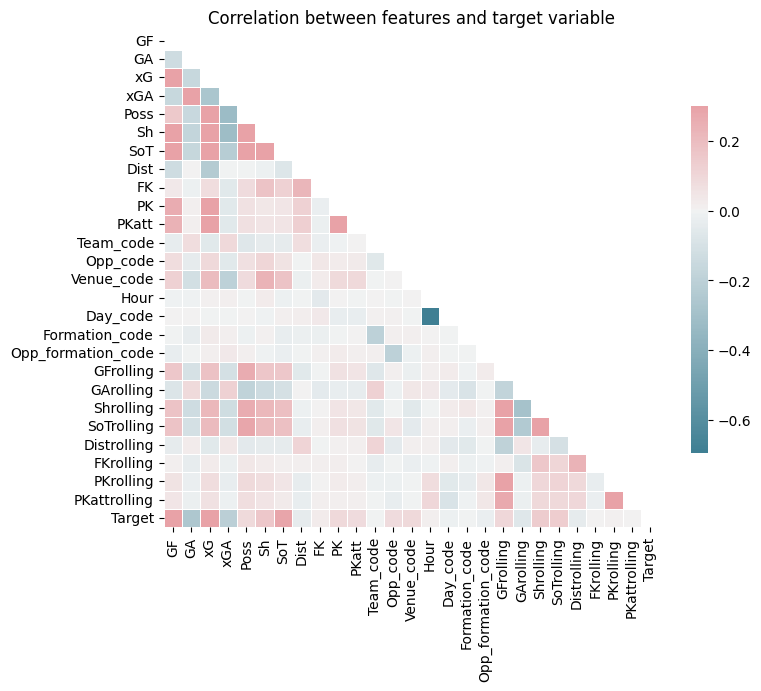

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
train = team_matches[team_matches['Date'] < '2025-01-01']
data = pd.concat([train.drop(columns=['Date', 'Target']), train['Target']], axis=1)

corr_mat = data.corr()                               # compute the correlation matrix

mask = np.zeros_like(corr_mat, dtype=bool)            # mask out upper triangle (correlation matrices are symmetric)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(8, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)   # generate custom colormap
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation between features and target variable')
plt.show()

In [18]:
train = team_matches[team_matches['Date'] < '2024-08-16']
test = team_matches[team_matches['Date'] > '2024-08-16']
train_X = train.drop(columns=['Date', 'Target'])
test_X = test.drop(columns=['Date', 'Target'])
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10)
}

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
clf.fit(train_X, train['Target'])
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X)
print(clf.best_params_)
print(classification_report(test['Target'], preds))

{'min_samples_split': np.int64(6), 'n_estimators': np.int64(190)}
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       181
           1       1.00      1.00      1.00       268
           2       0.99      1.00      0.99       270

    accuracy                           0.99       719
   macro avg       0.99      0.99      0.99       719
weighted avg       0.99      0.99      0.99       719



In [19]:
from sklearn.svm import SVC

svc_model = SVC(random_state=42)
param_grid = {
    'C': np.arange(0.1, 2, 0.1), 
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
svc_clf.fit(train_X, train['Target'])
refined_svc_model = svc_clf.best_estimator_
svc_preds = refined_svc_model.predict(test_X)
print(svc_clf.best_params_)
print(classification_report(test['Target'], svc_preds))

{'C': np.float64(1.9000000000000001), 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.81      0.49      0.61       181
           1       0.79      0.96      0.87       268
           2       0.91      0.96      0.93       270

    accuracy                           0.84       719
   macro avg       0.84      0.80      0.80       719
weighted avg       0.84      0.84      0.83       719

